# Figure 1 Notebook
Originally written by Derek Bogdanoff, edited for portability/clarity by George Hartoularos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import scanpy.api as sc
import scipy

/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


Some housekeeping:

In [2]:
sc.settings.verbosity=4
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


_GH:_ Adding a prefix here. The idea is that raw data will need to be downloaded separately from a repository (e.g. GEO) and may be in a random location on a person's computer. By having a separate file that all the notebooks read in once, they only have to edit that document with the path to the folder and then, assuming they have not changed the structure of that directory, all the notebooks will work without having to change path names in every single one.

In [3]:
with open('../../path.to.data.txt', 'r') as file:
    prefix = file.readline().strip()

_GH:_ Next 3 cells are commented out because the data on box does not have a directory called `20190319_miSeq`. Instead, it's called `20190319_cell_line_exp` and it's already an h5ad.

In [4]:
# #designate working directory 
# #path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
# #for scanpy annotations: barcodes.tsv, genes.tsv
# #
# #

# path='/Users/derekbogdanoff/projects/XYZeq/data/20190319_miSeq/human_mouse_gene_count/'

# plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'

In [5]:
# sc.settings.verbosity=3
# sc.settings.set_figure_params(dpi=80)
# sc.logging.print_versions()
# results_file = './write/results.h5ad'

# #sc.settings = True

# ##load the data
# adata=sc.read(path + 'matrix.mtx', cache=True).T


# ##name the genes
# adata.var_names = [gene.strip() for gene in open(path + 'genes2.tsv', 'r')]


# ##name the cells
# adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




In [6]:
# adata.var_names_make_unique()

_GH:_ Instead, loading in the h5ad. @Derek should upload the original files to Box if we'd like to convert them here. Otherwise can just provide the h5ad to the community.

## Load Matrix and Filter

In [7]:
adata = sc.read_h5ad(prefix + 'old_directories/20190319_cell_line_exp/20190319_cell_line.h5ad')

normalizing counts per cell
    finished (0:00:00)


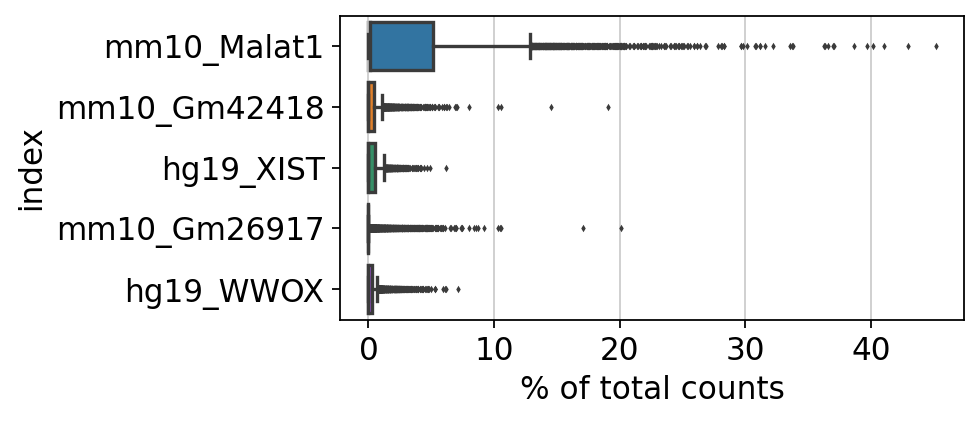

In [8]:
sc.pl.highest_expr_genes(adata, n_top=5) 

In [9]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, min_genes=100)

#sc.pp.filter_cells(adata, max_counts=15000)
#sc.pp.filter_cells(adata, max_genes=2000) 

##post processing filter genes 
sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 1365 cells that have less than 200 counts
filtered out 392 cells that have less than 100 genes expressed
filtered out 89764 genes that are detected in less than 2 cells


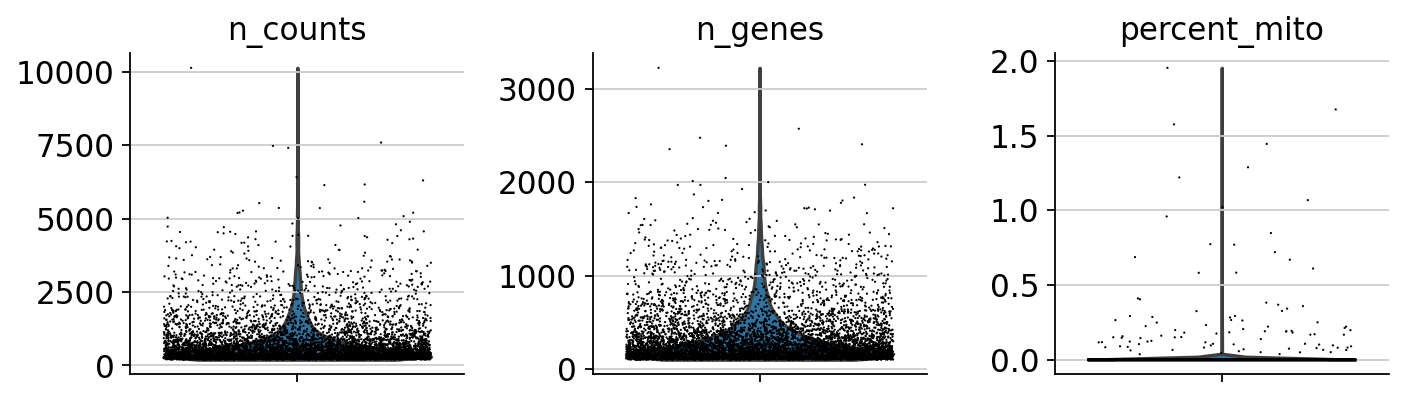

In [10]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)

In [11]:
##filter out outliers
adata = adata[adata.obs['n_genes'] < 15000, :]
adata = adata[adata.obs['n_counts'] < 10000, :]
adata = adata[adata.obs['percent_mito'] < 1, :]

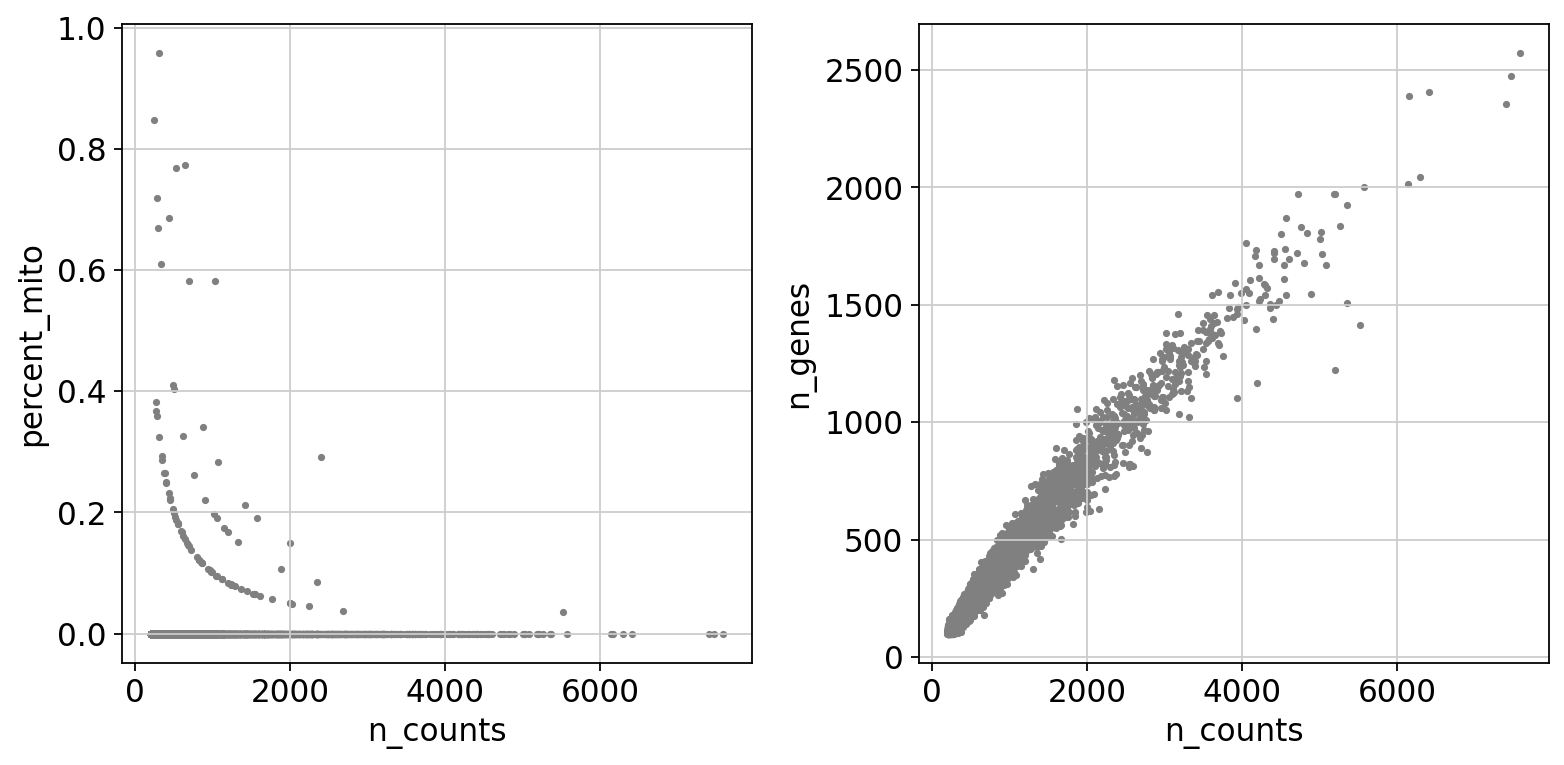

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for y, ax in zip(['percent_mito', 'n_genes'], ax):
    ax.scatter(adata.obs['n_counts'].values, adata.obs[y].values, color='gray', s=5)
    ax.set_xlabel('n_counts')
    ax.set_ylabel(y)
plt.tight_layout()

In [13]:
adata

View of AnnData object with n_obs × n_vars = 6510 × 31708
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

## Make Barnyard

In [14]:
mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
human_genes=[name for name in adata.var_names if name.startswith('hg19_')]

adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [15]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

In [16]:
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))

def cell_call(counts):
    if counts['ratio'] > 0.66:
        return 'M'
    elif counts['ratio'] < -0.66:
        return 'H'
    else:
        return 'C'

adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)

### Figure 1D:

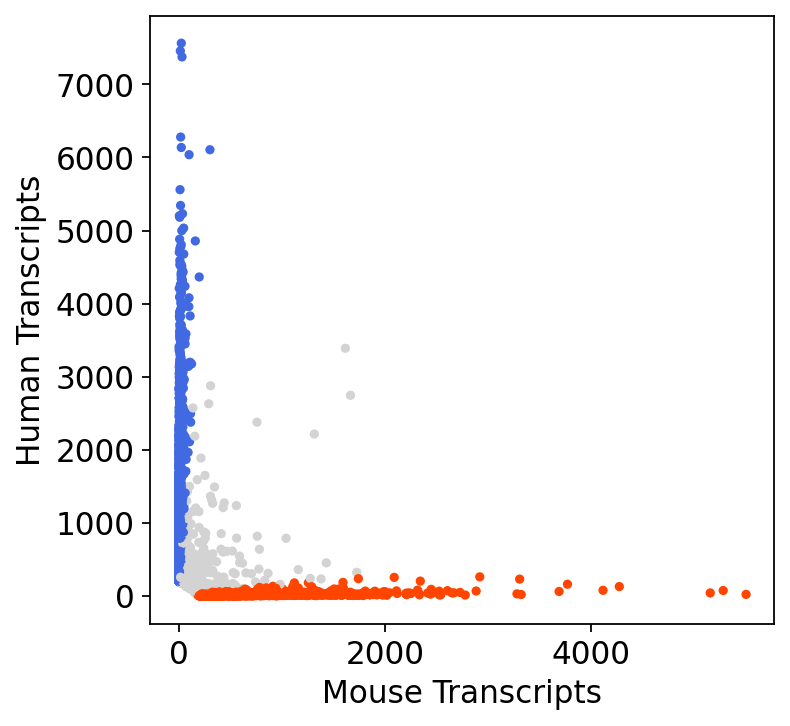

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap)

plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

In [18]:
adata.obs['cell_call'].value_counts()

H    4442
M    1734
C     334
Name: cell_call, dtype: int64

## Violin Plots

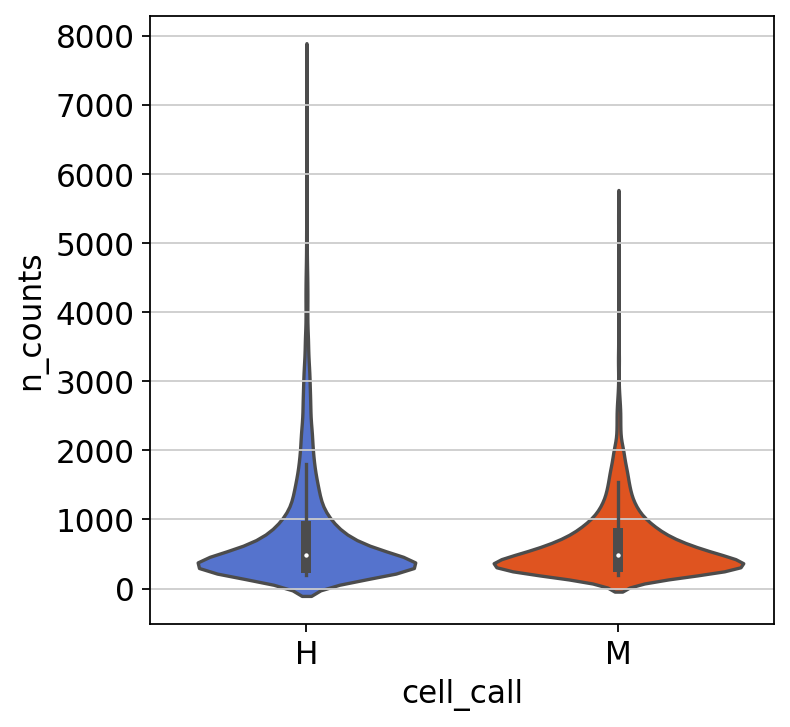

In [19]:
plt.figure(figsize=(5,5))
sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered']
              );

In [20]:
np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)

210.0

## Column Graphs Across Array

In [21]:
spatial_map=pd.read_csv(prefix + 'plate23_map.csv', header=None, names=['barcode', 'X', 'Y'])

In [22]:
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [23]:
df = pd.DataFrame(adata.obs.cell_call)
df['barcode']=df.index.str[-16:]
df.cell_call['cell_call']=df.cell_call.astype('category')
df = df.merge(spatial_map,on='barcode',how='right')
df = df.dropna()

In [24]:
list_= list()

for index, row in df.iterrows():
    if row['X'] % 2 != 0:
        row['Y']=row['Y']-0.5
    else:  
        row['Y']=row['Y']
    list_.append(row['Y'])

In [25]:
df['Y']=list_

In [26]:
df['Y']=df['Y']/2

In [27]:
color_dict={'H':'royalblue', 
            'M':'orangered',
            'C':'lightgrey',
           }

In [28]:
df['color']=df['cell_call'].map(color_dict)

In [29]:
df_bar=df.groupby('X')['cell_call'].value_counts(['']).unstack()

In [30]:
df_bar.columns.name='Cell Species'

In [31]:
df_bar=df_bar[['M','H','C']]

In [32]:
barplot_cmap=mpl.colors.ListedColormap(['red','royalblue','lightgrey'])

### Figure 1E:

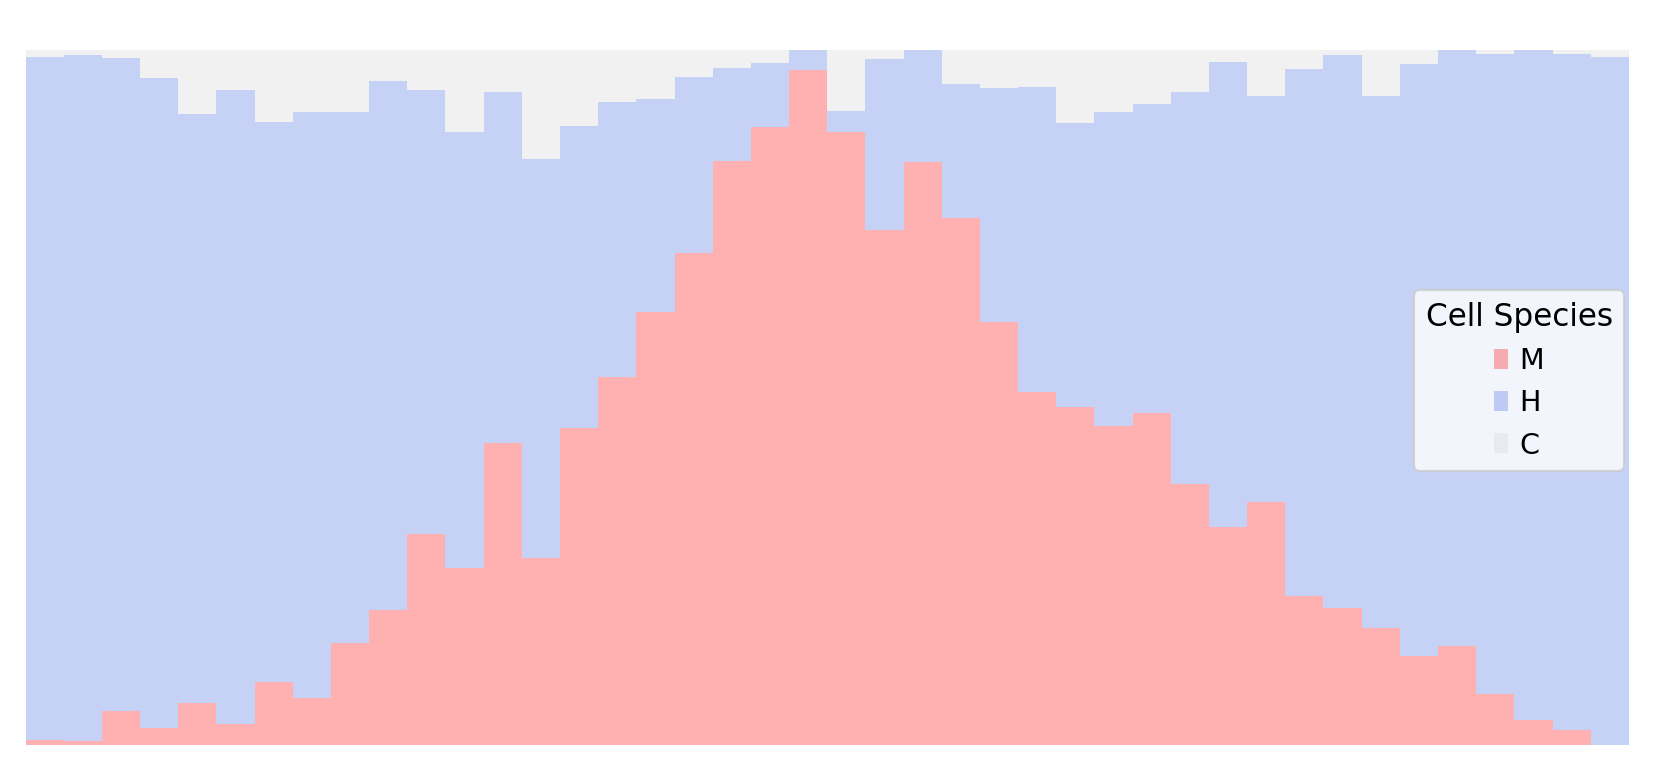

In [33]:
df_bar.plot.bar(stacked=True,
                width=1, 
                cmap=barplot_cmap, 
                ecolor='white',
               alpha=.3, figsize=(13, 6))
plt.axis('off')
plt.grid(False)             

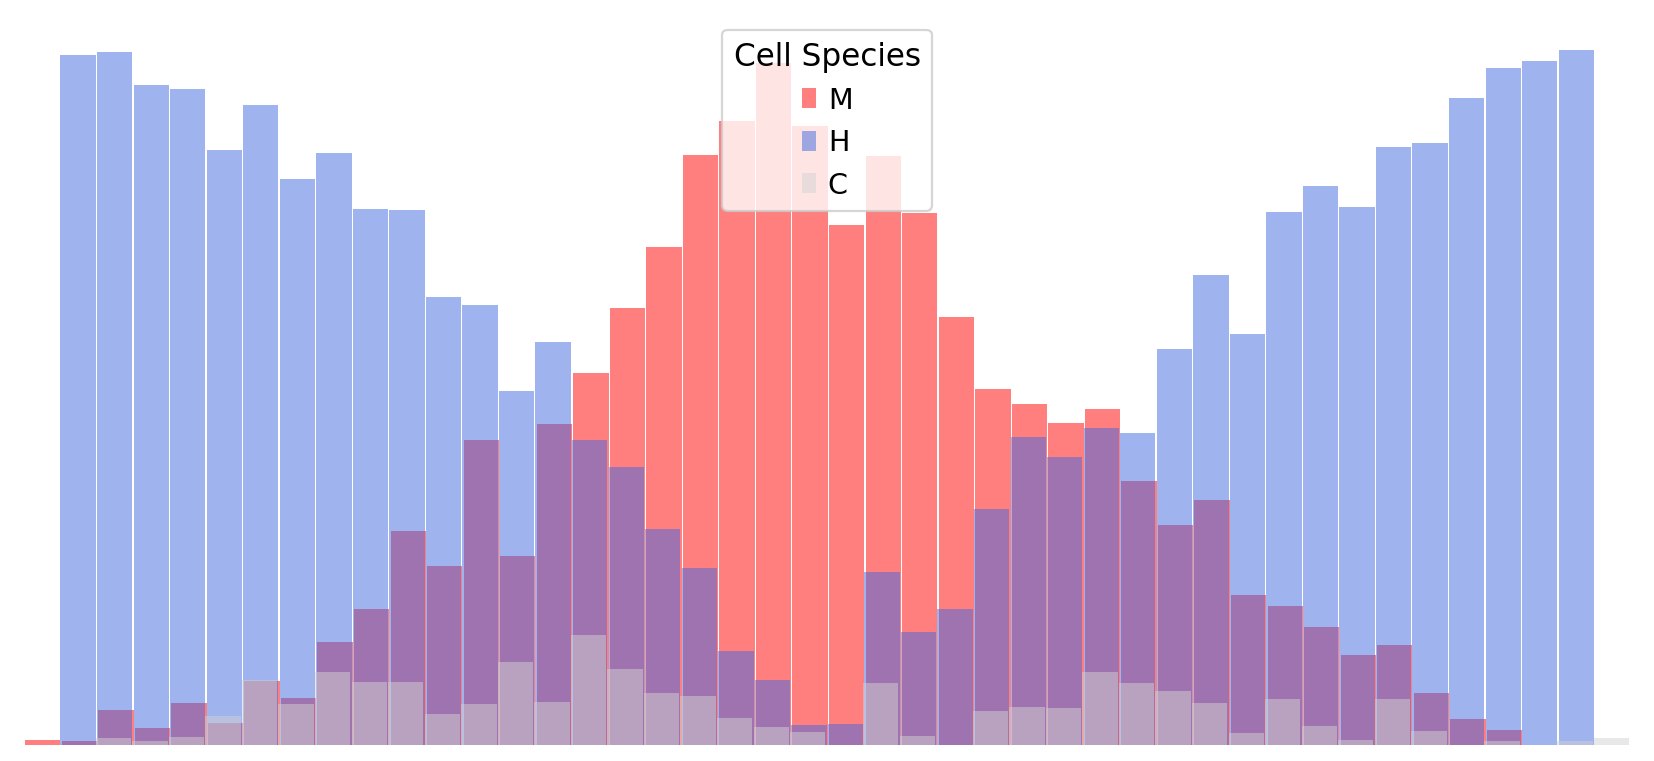

In [34]:
df_bar.plot.bar(stacked=False,
                width=2.9, 
                cmap=barplot_cmap, 
                ecolor='white',
                alpha=.5, figsize=(13, 6)
               )

plt.axis('off')
plt.grid(False)      

hi


In [61]:
df['counts']=adata.obs['n_counts'].reset_index()['n_counts']

In [62]:
df['log counts']=np.log10(df['counts'])

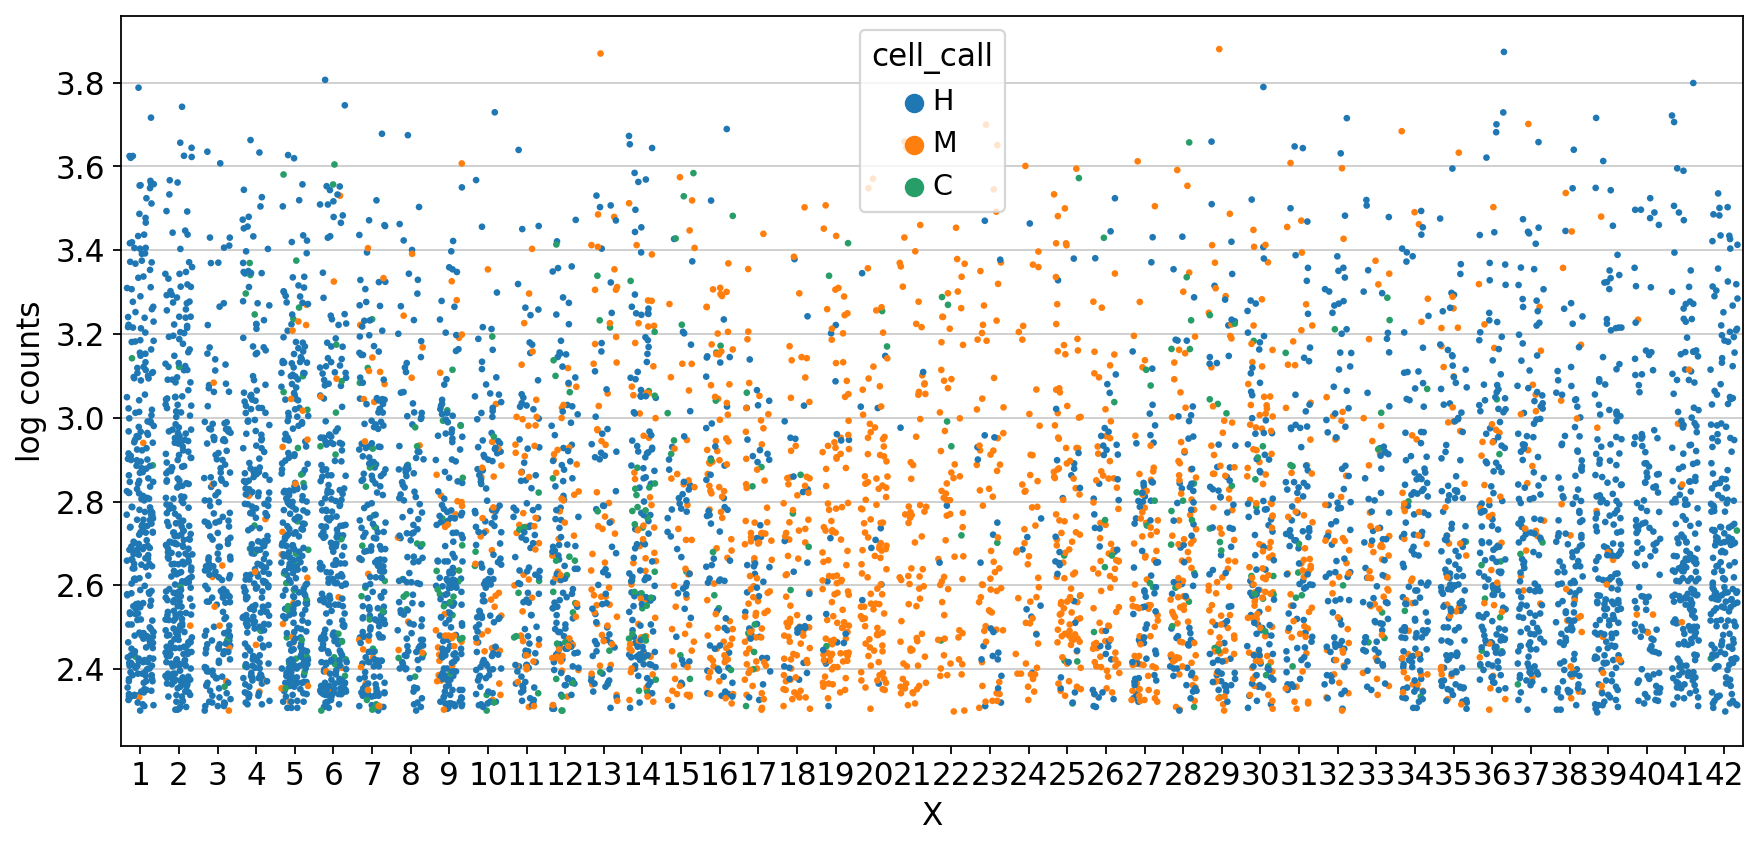

In [63]:
plt.figure(figsize=(13,6))
temp=sns.stripplot(x='X',
                   y='log counts', 
                   data=df, 
                   hue='cell_call',
                   jitter=0.35,
                   size=3)

In [64]:
df['X']=rand_jitter(df['X'])
df['Y']=rand_jitter(df['Y'])


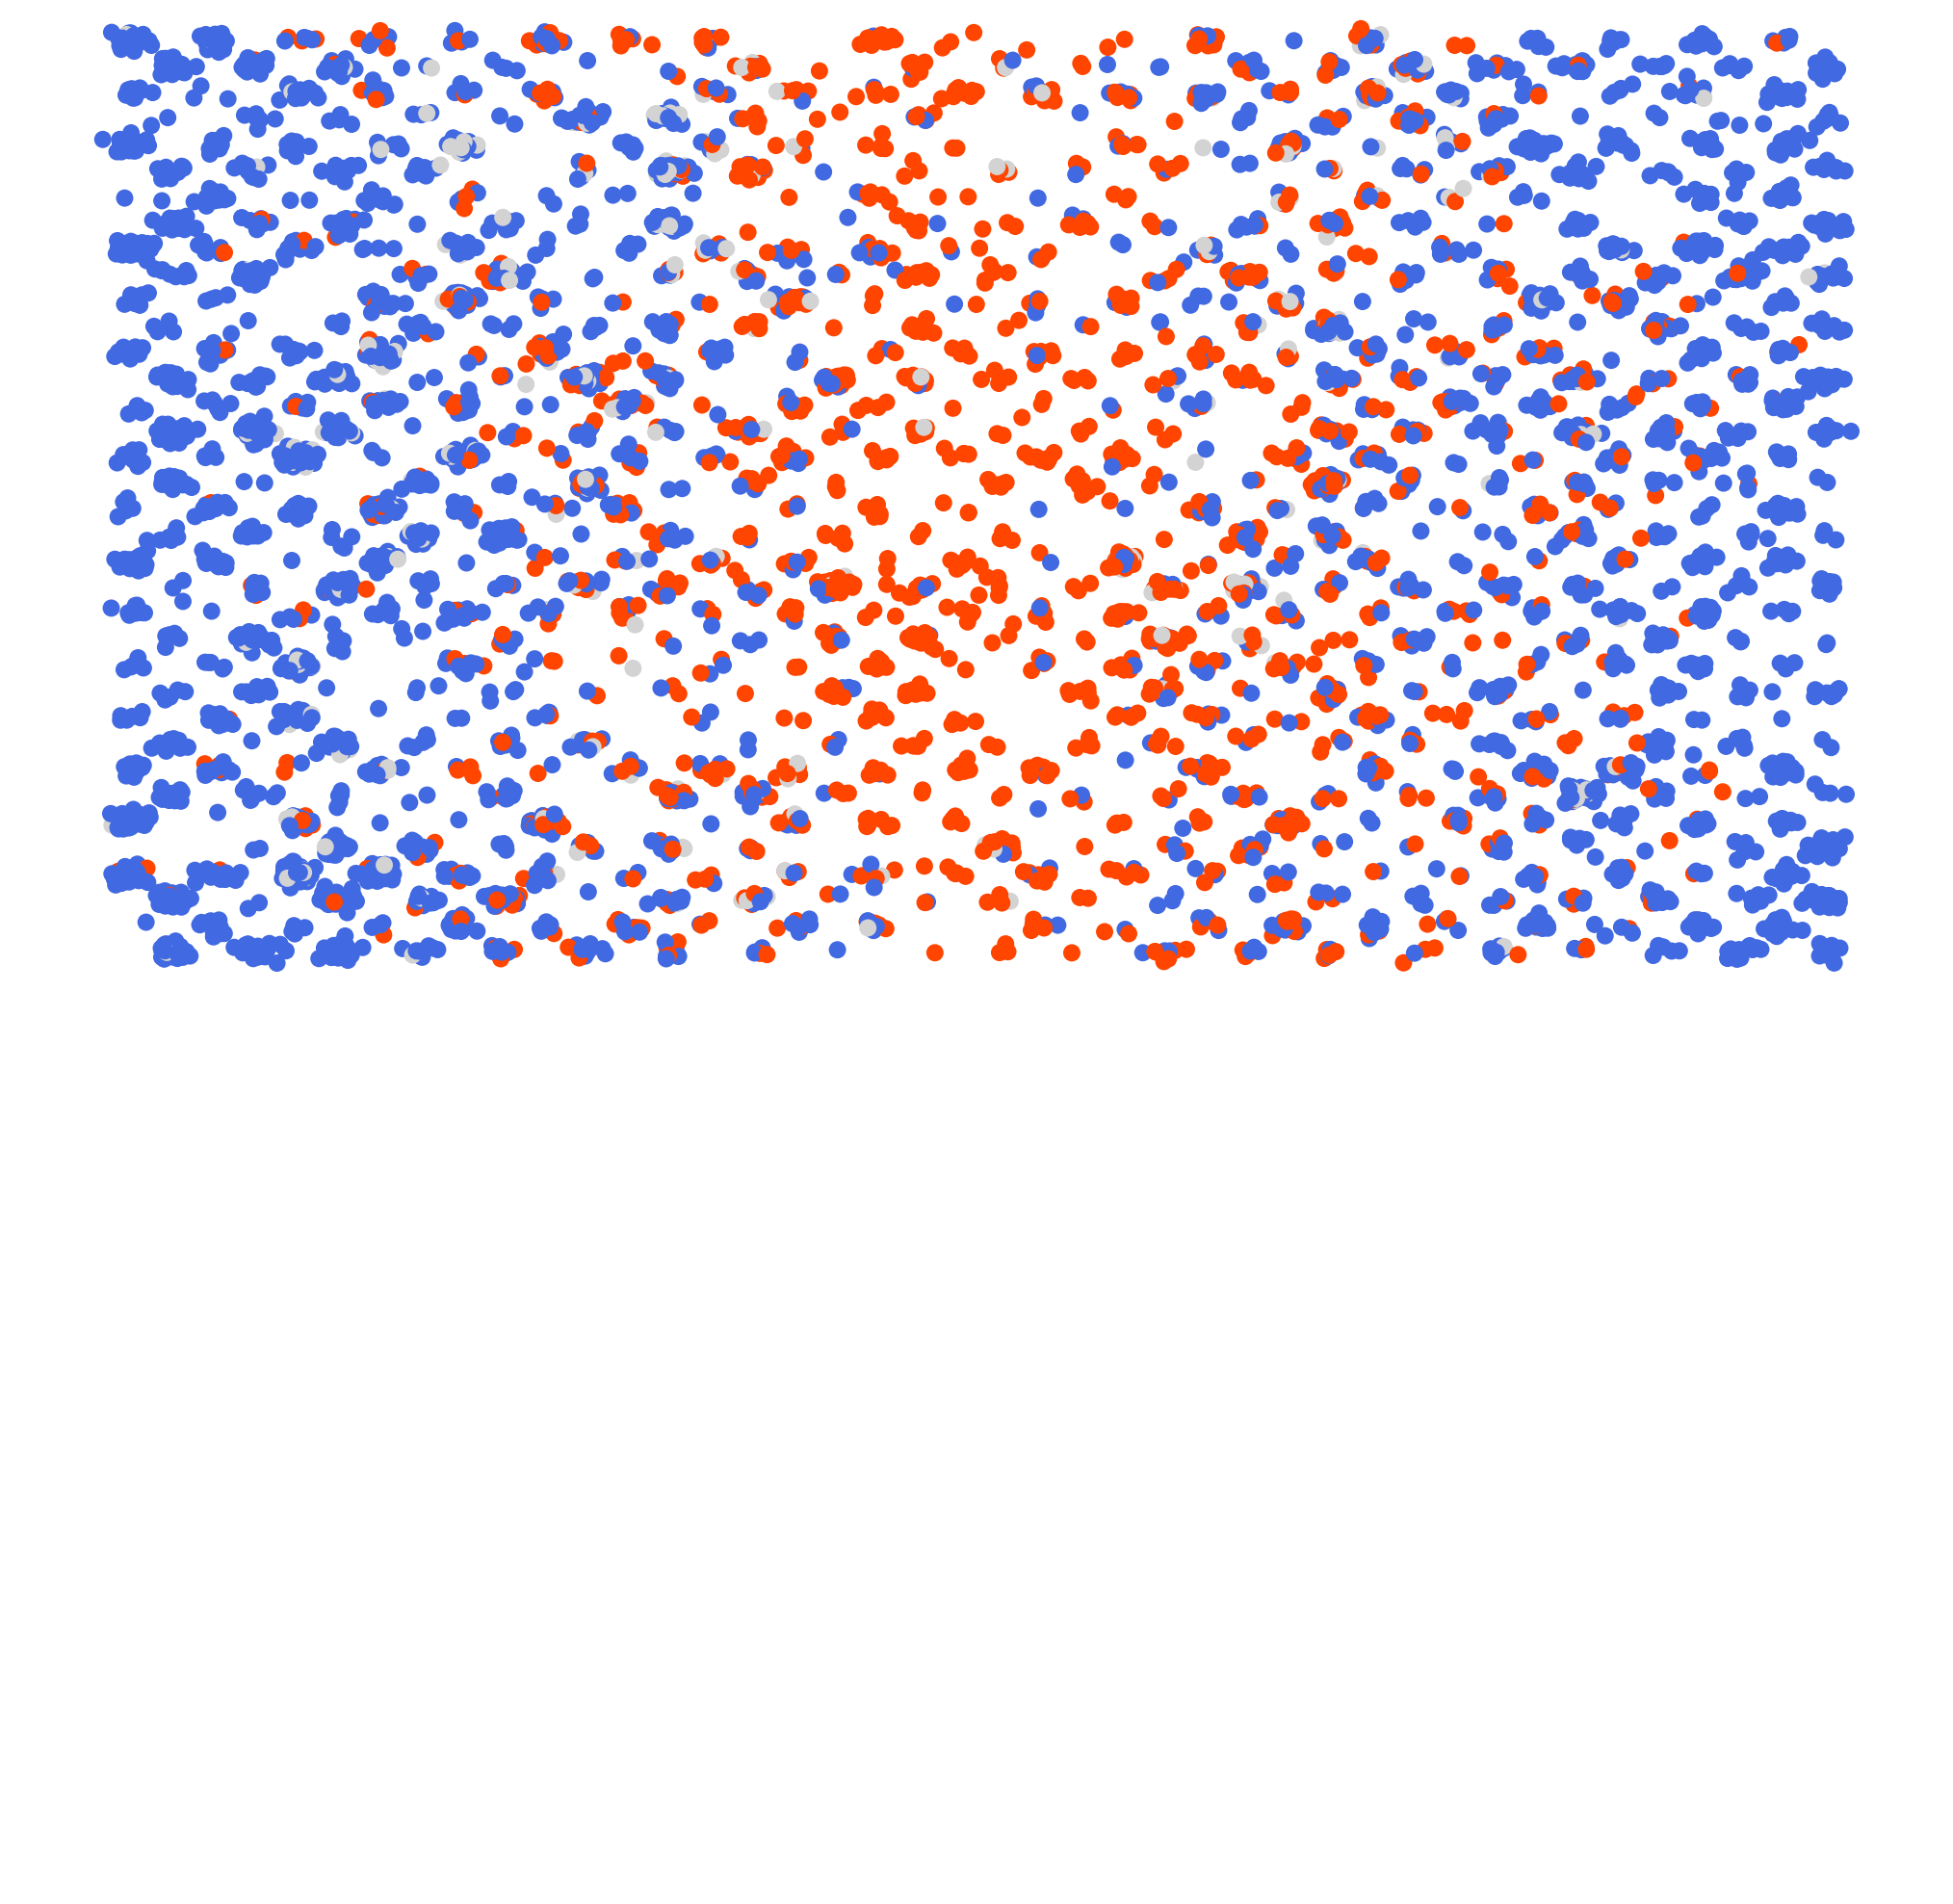

In [65]:
df.plot.scatter(x='X',y='Y',c=df['color'], s=50, 
                figsize=(16, 16)) # extra white space required to keep aspect ratio of plate
plt.ylim(18,0)

plt.axis('off')
plt.grid(False)